In [2]:
import os
import numpy as np
import geopandas as gpd
import leafmap
import openeo
from openeo.processes import lte
import xarray as xr
import matplotlib.pyplot as plt

/opt/conda/envs/eurac_env/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_260869/3206740976.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_

In [3]:
pv_geoms = gpd.read_file("./data/shapefiles/photovoltaic.shp")

threshold_area = 5000 #m^2 ~50mx100m
pv_geoms_32632 = pv_geoms.to_crs(32632)
big_pv_geoms_32632 = pv_geoms_32632.where(pv_geoms_32632["geometry"].area > threshold_area).dropna()
big_pv_geoms = big_pv_geoms_32632.to_crs(4326)
print(f"Number of selected PV Farms: {len(big_pv_geoms_32632)}")

Number of selected PV Farms: 43


Visualize a couple of Solar Farms polygons:

In [3]:
m = leafmap.Map(center=[48.087, 14.51], zoom=17,basemap="Esri.WorldImagery")
m.add_gdf(big_pv_geoms, layer_name="PV")
m

Map(center=[48.087, 14.51], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

This data somes from OSM.

Can we validate it with the one from DescartesLab?

To be sure that the polygons we use are actually covered by PV panels.

Filtering by size, keeping only the polygons covering a large area (how to defined "large"?):

Download the Sentinel-2 data with openEO Platform for each polygon

In [4]:
conn = openeo.connect("openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


In [5]:

# for i, geom in big_pv_geoms_32632.iterrows():
#     if os.path.exists(f"S2_2022_{i}.nc"):
#         continue
#     print(i)
#     print(geom["geometry"])
#     aoi = np.round(geom["geometry"].buffer(20).bounds,-1)
#     collection = "SENTINEL2_L2A"
#     spatial_extent = {"west": aoi[0],
#                       "east": aoi[2],
#                       "south": aoi[1],
#                       "north": aoi[3],
#                      "crs":"EPSG:32632"}
#     temporal_extent = ["2022-01-01","2022-12-31"]
#     all_bands = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12","SCL"]
#     properties={"eo:cloud_cover": lambda x: lte(x, 50)}
    
#     s2_cube = conn.load_collection(
#         collection,
#         temporal_extent = temporal_extent,
#         spatial_extent = spatial_extent,
#         bands = all_bands,
#         properties = properties
#     )
#     try:
#         s2_cube.download(f"./data/netcdfs/S2_2022_{i}.nc")
#     except:
#         continue

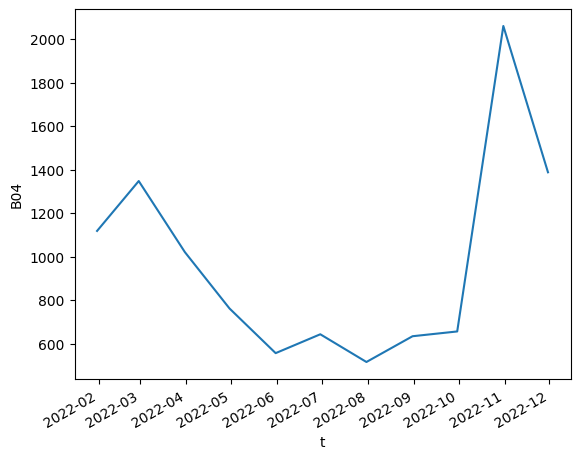

In [4]:
for i, geom in big_pv_geoms_32632.iterrows():
    if i==813: # Showing the plot for an area I'm pretty sure it's covered by PV Panels
        if not os.path.exists(f"./data/netcdfs/S2_2022_{i}.nc"):
            continue
        data = xr.open_dataset(f"./data/netcdfs/S2_2022_{i}.nc",decode_coords="all")
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        clipped = clipped.where(~cloud_mask)
        #aoi_mean = clipped.mean(dim=["x","y"],skipna=True).resample({"t": "W"}).mean() #Resampling to weekly, maybe required to align different time series
        aoi_mean = clipped.mean(dim=["x","y"],skipna=True).resample({"t": "M"}).mean()
        #aoi_mean = clipped.mean(dim=["x","y"],skipna=True) # Computing the mean over the area which should be covered by the panels. Other statistics can be computed
        aoi_mean.B04.plot()
        break

Now that we have the time series of Sentinel-2 values for the polygons covering the PV Farms:
- Do we need other polygons covering the non-PV class?
- Can we cluster the current data and check the result? (Don't include the SCL band)
- Can we add a filtering of the polygons based on DescartesLab data/result?

### Cluster

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


#### Monthly mean

In [47]:
band_values = []
ids = []
for i, geom in big_pv_geoms_32632.iterrows():
    try:
        data = xr.open_dataset(f"./data/netcdfs/S2_2022_{i}.nc",decode_coords="all")
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        clipped = clipped.where(~cloud_mask)
        #aoi_mean = clipped.mean(dim=["x","y"],skipna=True).resample({"t": "W"}).mean() #Resampling to weekly, maybe required to align different time series
        aoi_mean = clipped.mean(dim=["x","y"],skipna=True).resample({"t": "M"}).mean()
        #aoi_mean = clipped.mean(dim=["x","y"],skipna=True) # Computing the mean over the area which should be covered by the panels. Other statistics can be computed
        arr = aoi_mean.to_array().values[:11,]
        arr = arr.reshape(-1)
        band_values.append(arr)
        ids.append(i)
        #reshaped_arr = arr.reshape(-1)

    except:
        print(i)


800


In [48]:
bands = list(aoi_mean.to_array()['variable'].values[:11])

columns=[]
for b in bands:
    for t in range(12):
        columns.append(f'{b}_{t+1}')
        
        
data = pd.DataFrame(band_values, columns=columns)
data = data.fillna(-9999)


##### Silhouette Score:

1. Silhouette analysis measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
2. A higher silhouette score indicates better-defined clusters.

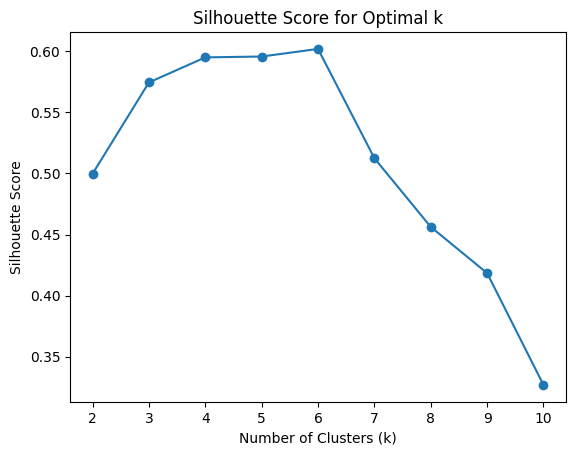

In [49]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

# Plot silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

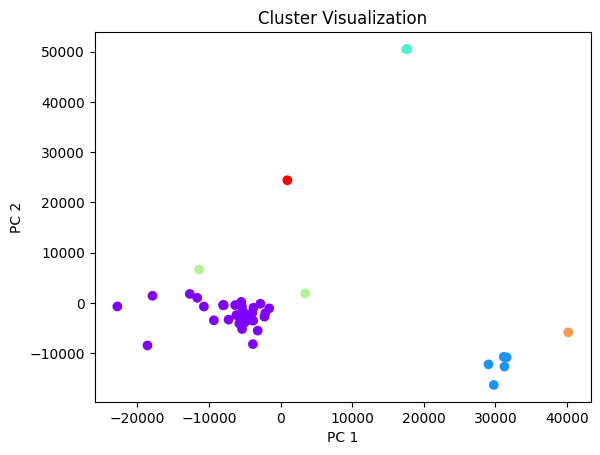

In [18]:
k = 6

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=1234)
data['Cluster'] = kmeans.fit_predict(data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['Cluster'], cmap='rainbow')
plt.title('Cluster Visualization')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

#### Weekly mean

In [54]:
band_values = []
ids = []
for i, geom in big_pv_geoms_32632.iterrows():
    try:
        data = xr.open_dataset(f"./data/netcdfs/S2_2022_{i}.nc",decode_coords="all")
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        clipped = clipped.where(~cloud_mask)
        aoi_mean = clipped.mean(dim=["x","y"],skipna=True).resample({"t": "W"}).mean() #Resampling to weekly, maybe required to align different time series
        #aoi_mean = clipped.mean(dim=["x","y"],skipna=True) # Computing the mean over the area which should be covered by the panels. Other statistics can be computed
        arr = aoi_mean.to_array().values[:11,]
        arr = arr.reshape(-1)
        band_values.append(arr)
        ids.append(i)
        #reshaped_arr = arr.reshape(-1)

    except:
        print(i)


800


In [55]:
bands = list(aoi_mean.to_array()['variable'].values[:11])

columns=[]
for b in bands:
    for t in range(53):
        columns.append(f'{b}_{t+1}')
        
        
data = pd.DataFrame(band_values, columns=columns)
data = data.fillna(-9999)

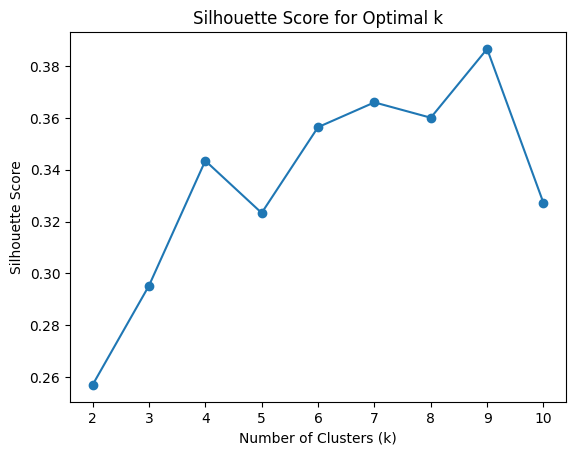

In [56]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

# Plot silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

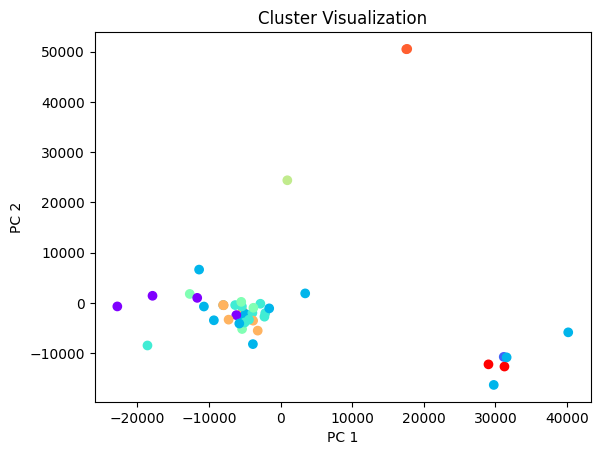

In [57]:
k = 9

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=1234)
data['Cluster'] = kmeans.fit_predict(data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['Cluster'], cmap='rainbow')
plt.title('Cluster Visualization')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()